<a href="https://colab.research.google.com/github/probml/probml-notebooks/blob/main/notebooks/gp_poisson_1d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# GP with a Poisson Likelihood

https://tinygp.readthedocs.io/en/latest/tutorials/likelihoods.html

We use the tinygp library to define the model, and the numpyro library to do inference, using either MCMC or SVI.


In [2]:
try:
    import tinygp
except ImportError:
    %pip install -q tinygp

try:
    import numpyro
except ImportError:
    # It is much faster to use CPU than GPU.
    # This is because Colab has multiple CPU cores, so can run the 2 MCMC chains in parallel
    %pip uninstall -y jax jaxlib
    %pip install -q numpyro jax jaxlib
    #%pip install numpyro[cuda] -f https://storage.googleapis.com/jax-releases/jax_releases.html

try:
    import arviz
except ImportError:
    %pip install arviz

/usr/local/lib/python3.7/dist-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)


# Data

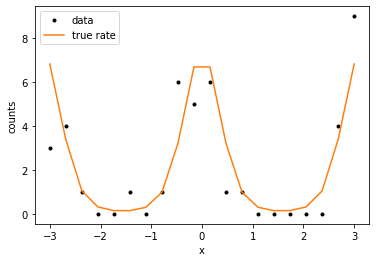

In [3]:
import numpy as np
import matplotlib.pyplot as plt

random = np.random.default_rng(203618)
x = np.linspace(-3, 3, 20)
true_log_rate = 2 * np.cos(2 * x)
y = random.poisson(np.exp(true_log_rate))
plt.plot(x, y, ".k", label="data")
plt.plot(x, np.exp(true_log_rate), "C1", label="true rate")
plt.legend(loc=2)
plt.xlabel("x")
_ = plt.ylabel("counts")

plt.savefig("gp-poisson-data.pdf")

# Markov chain Monte Carlo (MCMC)

We set up the model in `numpyro` and run  MCMC.
Note that  the `log_rate` parameter doesn't have the `obs=...` argument set, since it is latent.

In [4]:
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from tinygp import kernels, GaussianProcess

# We'll enable float64 support here for better numerical performance
from jax.config import config

config.update("jax_enable_x64", True)


def model(x, y=None):
    # The parameters of the GP model
    mean = numpyro.sample("mean", dist.Normal(0.0, 2.0))
    sigma = numpyro.sample("sigma", dist.HalfNormal(3.0))
    rho = numpyro.sample("rho", dist.HalfNormal(10.0))

    # Set up the kernel and GP objects
    kernel = sigma**2 * kernels.Matern52(rho)
    gp = GaussianProcess(kernel, x, diag=1e-5, mean=mean)

    # This parameter has shape (num_data,) and it encodes our beliefs about
    # the process rate in each bin
    log_rate = numpyro.sample("log_rate", gp.numpyro_dist())

    # Finally, our observation model is Poisson
    numpyro.sample("obs", dist.Poisson(jnp.exp(log_rate)), obs=y)


# Run the MCMC
nuts_kernel = numpyro.infer.NUTS(model, target_accept_prob=0.9)
mcmc = numpyro.infer.MCMC(
    nuts_kernel,
    num_warmup=500,
    num_samples=500,
    num_chains=2,
    progress_bar=False,
)
rng_key = jax.random.PRNGKey(55873)
mcmc.run(rng_key, x, y=y)
samples = mcmc.get_samples()

/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:280: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains


We can summarize the MCMC results by plotting our inferred model (here we're showing the 1- and 2-sigma credible regions), and compare it to the known ground truth:

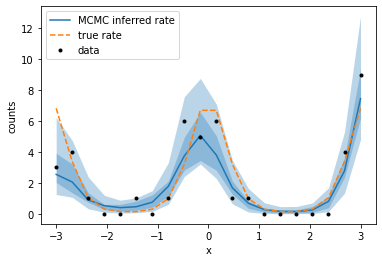

In [5]:
q = np.percentile(samples["log_rate"], [5, 25, 50, 75, 95], axis=0)
plt.plot(x, np.exp(q[2]), color="C0", label="MCMC inferred rate")
plt.fill_between(x, np.exp(q[0]), np.exp(q[-1]), alpha=0.3, lw=0, color="C0")
plt.fill_between(x, np.exp(q[1]), np.exp(q[-2]), alpha=0.3, lw=0, color="C0")
plt.plot(x, np.exp(true_log_rate), "--", color="C1", label="true rate")
plt.plot(x, y, ".k", label="data")
plt.legend(loc=2)
plt.xlabel("x")
_ = plt.ylabel("counts")

plt.savefig("gp-poisson-mcmc.pdf")

# Stochastic variational inference (SVI)

For larger datasets, it is faster to use stochastic variational inference (SVI) instead of MCMC.


In [6]:
def guide(x, y=None):
    numpyro.param("mean", jnp.zeros(()))
    numpyro.param("sigma", jnp.ones(()), constraint=dist.constraints.positive)
    numpyro.param("rho", 2 * jnp.ones(()), constraint=dist.constraints.positive)
    mu = numpyro.param("log_rate_mu", jnp.zeros_like(x) if y is None else jnp.log(y + 1))
    sigma = numpyro.param(
        "log_rate_sigma",
        jnp.ones_like(x),
        constraint=dist.constraints.positive,
    )
    numpyro.sample("log_rate", dist.Normal(mu, sigma))


optim = numpyro.optim.Adam(0.01)
svi = numpyro.infer.SVI(model, guide, optim, numpyro.infer.Trace_ELBO(10))
results = svi.run(jax.random.PRNGKey(55873), 3000, x, y=y, progress_bar=False)

As above, we can plot our inferred conditional model and compare it to the ground truth:

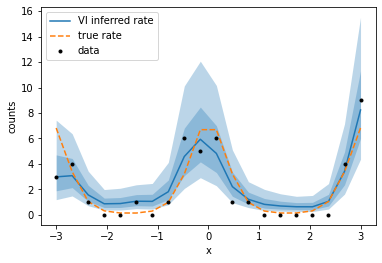

In [7]:
mu = results.params["log_rate_mu"]
sigma = results.params["log_rate_sigma"]
plt.plot(x, np.exp(mu), color="C0", label="VI inferred rate")
plt.fill_between(
    x,
    np.exp(mu - 2 * sigma),
    np.exp(mu + 2 * sigma),
    alpha=0.3,
    lw=0,
    color="C0",
)
plt.fill_between(x, np.exp(mu - sigma), np.exp(mu + sigma), alpha=0.3, lw=0, color="C0")
plt.plot(x, np.exp(true_log_rate), "--", color="C1", label="true rate")
plt.plot(x, y, ".k", label="data")
plt.legend(loc=2)
plt.xlabel("x")
_ = plt.ylabel("counts")

plt.savefig("gp-poisson-svi.pdf")